# Fashion Image Classification with a Custom CNN in PyTorch

###  1.  Project Introduction

This project aims to build a **Convolutional Neural Network (CNN)** using the **PyTorch framework** to classify images in the **Fashion-MNIST dataset**.

**Fashion-MNIST** is a dataset. It contains **10 categories of clothing items**, including:

- T-shirt/top
- Trouser
- Sneaker
- Bag
- Ankle boot  
- ... and others, each represented as a **28×28 grayscale image**.

We designed a **custom 3-layer CNN architecture** incorporating:

-  **Batch Normalization**
-  **MaxPooling**
-  **Dropout Regularization**

to enhance the model’s **generalization and robustness**.

During training, we applied:

-  **ReduceLROnPlateau** scheduler
-  **EarlyStopping** strategy

to accelerate convergence and prevent overfitting.

After training, the model’s performance was evaluated on the test set using:

-  Accuracy & loss curves
-  Confusion matrix
-  Visual inspection of predictions

for comprehensive performance analysis.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import gzip
import struct
from tqdm.notebook import tqdm

In [2]:
# 设置随机种子以确保结果可复现
torch.manual_seed(42)
np.random.seed(42)

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Use device: {device}")

# 定义Fashion-MNIST数据加载函数
def load_mnist(path, kind='train'):
    import os, gzip, numpy as np

    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16)\
                  .reshape(len(labels), 28, 28)

    return images, labels

# 加载训练集和测试集
data_dir = './data'

train_images, train_labels = load_mnist(data_dir, kind='train')
test_images, test_labels = load_mnist(data_dir, kind='t10k')




Use device: cpu


### 2. Data Loading & Preprocessing

1. **Normalize pixel values to [0,1]**  
   The original grayscale images have pixel values ranging from 0 to 255. We scale them down to [0,1] to improve training stability.

2. **Add channel dimension**  
   CNNs expect input in the shape `[batch_size, channels, height, width]`. Since Fashion-MNIST images are grayscale, we add an explicit channel dimension, transforming shape from `(N, 28, 28)` to `(N, 1, 28, 28)`.

3. **Convert to PyTorch tensors**  
   The preprocessed NumPy arrays are converted to PyTorch tensors, and the labels are cast to `long` to match the requirements of `CrossEntropyLoss`.

4. **Create DataLoaders**  
   We wrap the training and test tensors into `TensorDataset` objects and use `DataLoader` for batching. The training set is shuffled to ensure random sampling, while the test set remains ordered for evaluation.

In [67]:
# 1. Normalize pixel values to [0,1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# 2. Add channel dimension
train_images = train_images.reshape(-1, 1, 28, 28)
test_images = test_images.reshape(-1, 1, 28, 28)

# 3. Convert to PyTorch tensors
X_train = torch.tensor(train_images)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_test = torch.tensor(test_images)
y_test = torch.tensor(test_labels, dtype=torch.long)

# 4. Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [72]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.view(b, c, -1).mean(dim=2)  # Global Average Pooling
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

# Define the CNN model
class FashionCNN(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super(FashionCNN, self).__init__()
        # The first convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.se1 = SEBlock(32)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        
        # The second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.se2 = SEBlock(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        
        # The third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.se3 = SEBlock(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        
        # Fully connected layer
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # The first convolutional block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.se1(x)  
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # The second convolutional block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.se2(x)  
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # The third convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.se3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
       
        x = x.view(x.size(0), -1)
        
        # Fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

### 3.  Model Training & Configuration

We configure the training process with standard hyperparameters and strategies to ensure stability and generalization:

- `learning_rate = 0.001`: Controls the step size during optimization.
- `weight_decay = 1e-5`: L2 regularization to prevent overfitting.
- `num_epochs = 20`: Number of complete passes through the training data.

#### Optimization:

- **Loss**: `CrossEntropyLoss` is used for multi-class classification.
- **Optimizer**: `Adam` is selected for its adaptive learning rate capabilities.
- **Scheduler**: `ReduceLROnPlateau` decreases the learning rate if validation loss stagnates, helping fine-tune the model near convergence.

#### Early Stopping:

A custom `EarlyStopping` class is implemented to halt training when validation loss does not improve for `patience=5` consecutive epochs, preventing overfitting and reducing unnecessary computation.


In [73]:
# Define hyperparameters
learning_rate = 0.001
weight_decay = 1e-5 
num_epochs = 20

# Create the model
model = FashionCNN().to(device)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (se1): SEBlock(
    (fc1): Linear(in_features=32, out_features=2, bias=True)
    (fc2): Linear(in_features=2, out_features=32, bias=True)
  )
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (se2): SEBlock(
    (fc1): Linear(in_features=64, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=64, bias=True)
  )
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (se3): SEBlock(
    (fc

### 4. Full Training Loop & Performance Tracking

This section defines a full training pipeline with three components:

#### 1. `train_one_epoch()`
Performs one epoch of training:
- Sets model to training mode
- Iterates through batches, performs forward/backward propagation
- Updates weights and computes average loss/accuracy

#### 2. `evaluate()`
Evaluates the model on the validation set:
- Disables gradient computation
- Calculates total loss, accuracy, and collects predictions
- Useful for plotting confusion matrix and classification reports

#### 3. `train_model()`
Coordinates the full training loop:
- Repeats training & validation for each epoch
- Logs loss and accuracy
- Adjusts learning rate dynamically
- Implements early stopping
- Saves the best-performing model based on validation accuracy

The returned `history` object is essential for visualizing performance trends over epochs.


In [74]:
# Training and evaluation functions
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Gradient clearing
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward propagation
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
          
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)

# training model
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_weights = None
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train an epoch
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # verify
        val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)
        
        # update learing rate
        scheduler.step(val_loss)
        
        # record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = model.state_dict().copy()
            print(f"Save new best models and verify accuracy: {val_acc:.4f}")
            torch.save(model.state_dict(), 'results/best_fashion_mnist_model.pth')
        
        # early stop
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stop triggered at epoch {epoch+1}")
            break
    
    # load the best model weights
    model.load_state_dict(best_model_weights)
    return model, history


Epoch 1/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.4994, Train Acc: 0.8171
Val Loss: 0.3267, Val Acc: 0.8786
Save new best models and verify accuracy: 0.8786
Epoch 2/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.3328, Train Acc: 0.8785
Val Loss: 0.2807, Val Acc: 0.8975
Save new best models and verify accuracy: 0.8975
Epoch 3/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2924, Train Acc: 0.8934
Val Loss: 0.2766, Val Acc: 0.8982
Save new best models and verify accuracy: 0.8982
Epoch 4/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2718, Train Acc: 0.8991
Val Loss: 0.2565, Val Acc: 0.9078
Save new best models and verify accuracy: 0.9078
Epoch 5/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2545, Train Acc: 0.9056
Val Loss: 0.2543, Val Acc: 0.9067
Epoch 6/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2404, Train Acc: 0.9114
Val Loss: 0.2420, Val Acc: 0.9109
Save new best models and verify accuracy: 0.9109
Epoch 7/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2334, Train Acc: 0.9146
Val Loss: 0.2279, Val Acc: 0.9158
Save new best models and verify accuracy: 0.9158
Epoch 8/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2201, Train Acc: 0.9186
Val Loss: 0.2205, Val Acc: 0.9218
Save new best models and verify accuracy: 0.9218
Epoch 9/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2124, Train Acc: 0.9216
Val Loss: 0.2249, Val Acc: 0.9170
Epoch 10/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2070, Train Acc: 0.9229
Val Loss: 0.2221, Val Acc: 0.9207
Epoch 11/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.2006, Train Acc: 0.9243
Val Loss: 0.2169, Val Acc: 0.9232
Save new best models and verify accuracy: 0.9232
Epoch 12/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1947, Train Acc: 0.9278
Val Loss: 0.2092, Val Acc: 0.9250
Save new best models and verify accuracy: 0.9250
Epoch 13/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1908, Train Acc: 0.9293
Val Loss: 0.2155, Val Acc: 0.9224
Epoch 14/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1846, Train Acc: 0.9323
Val Loss: 0.2134, Val Acc: 0.9272
Save new best models and verify accuracy: 0.9272
Epoch 15/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1777, Train Acc: 0.9336
Val Loss: 0.2086, Val Acc: 0.9262
Epoch 16/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1773, Train Acc: 0.9334
Val Loss: 0.2072, Val Acc: 0.9294
Save new best models and verify accuracy: 0.9294
Epoch 17/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1730, Train Acc: 0.9357
Val Loss: 0.2224, Val Acc: 0.9222
Epoch 18/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1682, Train Acc: 0.9361
Val Loss: 0.2100, Val Acc: 0.9256
Epoch 19/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1656, Train Acc: 0.9374
Val Loss: 0.2172, Val Acc: 0.9214
Epoch 20/20


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.1475, Train Acc: 0.9441
Val Loss: 0.2031, Val Acc: 0.9321
Save new best models and verify accuracy: 0.9321


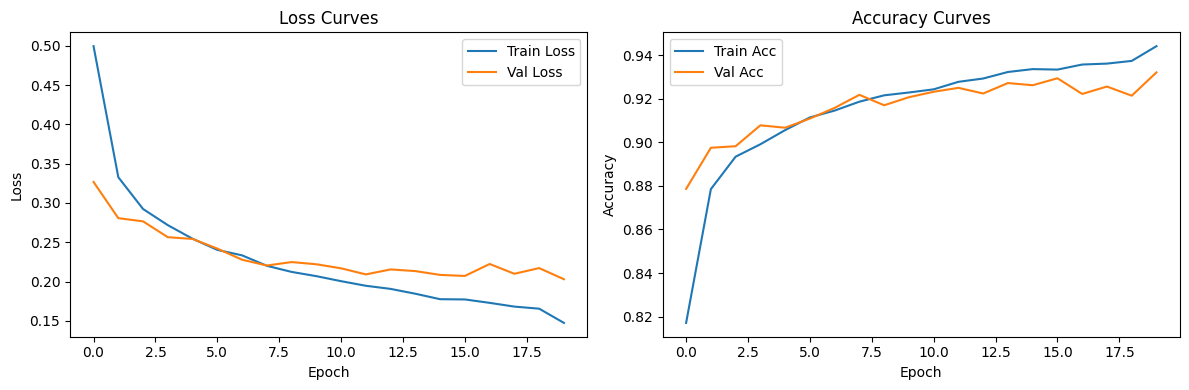

In [75]:
# training model
model, history = train_model(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs, 
    device
)

# plot curves
plt.figure(figsize=(12, 4))

# plot loss curves
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.savefig('results/training_curves.png')
plt.show()

### 
The above plots visualize training and validation performance across 20 epochs:

- **Training loss decreases steadily**, and validation loss stabilizes, indicating successful convergence.
- **Accuracy curves for training and validation are closely aligned**, suggesting no significant overfitting.
- The final training accuracy reaches approximately **94.5%**, while validation accuracy stabilizes around **93.0%**, demonstrating strong generalization performance.

These trends confirm that the custom CNN model is well-regularized and effectively trained.

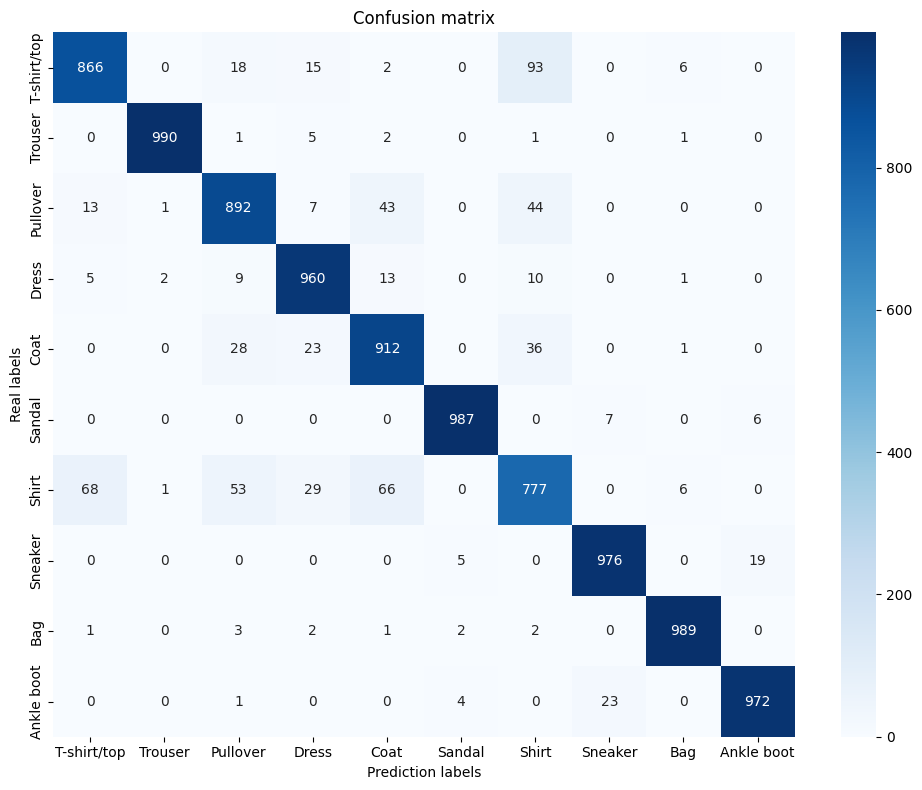

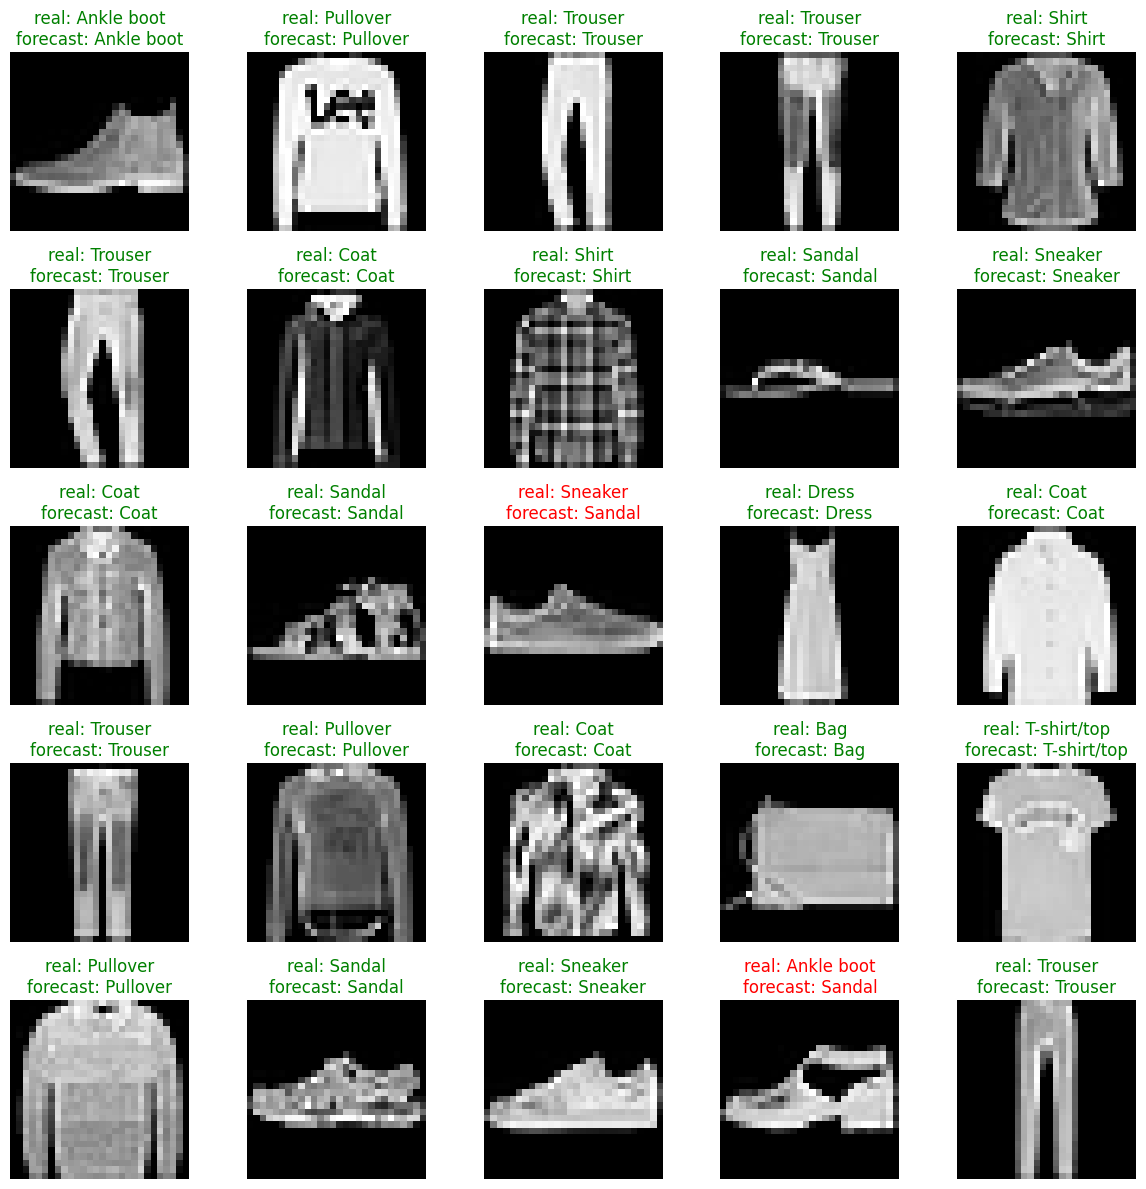

Model training and evaluation complete!


In [76]:
# Collect real and predictive labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        
# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediction labels')
plt.ylabel('Real labels')
plt.title('Confusion matrix')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png')
plt.show()

# Visualize some predictions
def visualize_predictions(model, test_loader, class_names, device, num_samples=25):
    model.eval()
    
    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples], labels[:num_samples]
    
    # Get Forecasts
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
    
    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        color = 'green' if preds[i] == labels[i] else 'red'
        plt.title(f"real: {class_names[labels[i]]}\nforecast: {class_names[preds[i]]}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/prediction_examples.png')
    plt.show()

visualize_predictions(model, test_loader, class_names, device)

# save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': class_names
}, 'results/fashion_mnist_model_full.pth')

print("Model training and evaluation complete!")

### Confusion Matrix Analysis

The confusion matrix reveals the model’s strengths and weaknesses in classifying different categories:

- Most classes achieve high classification accuracy, with nearly perfect values on the diagonal.
- Categories like **Trouser**, **Sandal**, **Bag**, **Sneaker**, and **Ankle boot** are easily distinguishable due to their distinctive shapes and rarely get misclassified.
- The model struggles more with **upper-body clothing** such as **T-shirt**, **Pullover**, **Coat**, and especially **Shirt**, which shows the highest rate of confusion with several other categories.

These misclassifications are expected, as these clothing types often share similar outlines and textures in grayscale images.

### 5. Final Summary & Future Work

In this project, we successfully developed a custom Convolutional Neural Network (CNN) using PyTorch to classify grayscale images from the Fashion-MNIST dataset. The model achieved strong performance with approximately **93% validation accuracy** and demonstrated robust generalization.

####  Key Achievements:

- Designed a 3-layer CNN incorporating Batch Normalization and Dropout to mitigate overfitting
- Integrated learning rate scheduling and early stopping to improve convergence and stability
- Evaluated the model comprehensively using accuracy/loss curves and a confusion matrix
- Achieved excellent classification performance on easily distinguishable categories (e.g., Sneaker, Trouser, Bag)

####  Limitations:

- The model struggles to differentiate visually similar upper-body garments (e.g., Shirt vs. T-shirt)
- The current architecture is relatively shallow and may not generalize well to more complex tasks

####  Future Directions:

- Explore attention mechanisms or lightweight CNN variants to balance performance and efficiency